In [1]:
from obspy.core import Stream, read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path

In [2]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'

stas = pd.read_csv(path + 'station_data.csv')
events = pd.read_csv(path + 'events_csv.csv')

In [3]:
stas

,Sta,Lat,Lon,Depth(m)
0,BCWB,24.2184,121.6891,-192
1,TRKB,24.1614,121.6127,-192
2,NTTB,24.1728,121.5259,-175
3,SJNB,24.1073,121.6006,-193
4,HGSB,23.4903,121.4237,-266
5,CHMB,23.4868,121.4703,-191
6,SSNB,23.4423,121.3981,-185
7,ZANB,23.3947,121.4585,-218
8,FBRB,23.1406,121.2796,-200
9,SSTB,23.1340,121.3782,-199


In [4]:
events

,evt_id,origin_time,lat,lon,depth
0,2009-10-03_M6.1,2009-10-03T17:36:06.120,23.630,121.452,28.0
1,2013-10-31_M6.3,2013-10-31T12:02:08.720,23.590,121.437,10.0
2,2018-02-04_M6.1,2018-02-04T13:56:41.950,24.157,121.708,12.0


2009-10-03_M6.1
BCWB
TRKB
NTTB
100.0
2009-10-03T17:35:36.119542Z


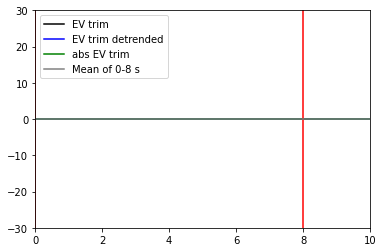

SJNB
HGSB
100.0
2009-10-03T17:35:36.119542Z


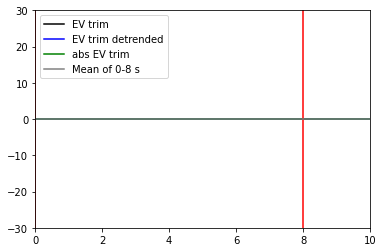

CHMB
SSNB
ZANB
100.0
2009-10-03T17:35:36.119542Z


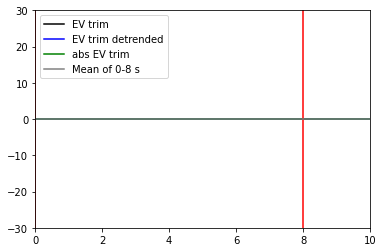

FBRB
100.0
2009-10-03T17:35:36.119542Z


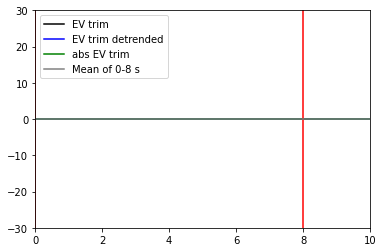

SSTB
DONB
2013-10-31_M6.3
BCWB
TRKB
100.0
2013-10-31T12:01:38.718393Z


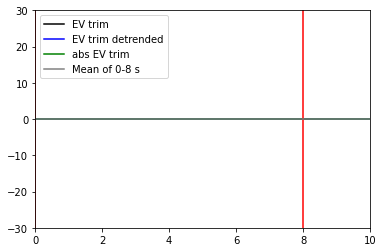

NTTB
SJNB
100.0
2013-10-31T12:01:38.718393Z


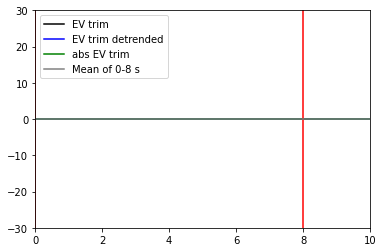

HGSB
100.0
2013-10-31T12:01:38.718393Z


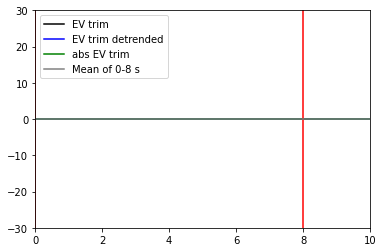

CHMB
100.0
2013-10-31T12:01:38.718393Z


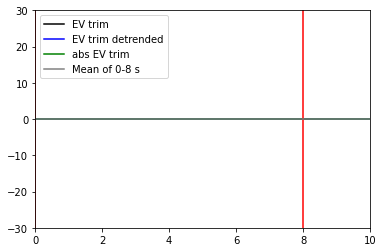

SSNB
100.0
2013-10-31T12:01:38.718393Z


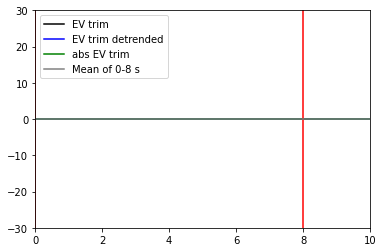

ZANB
100.0
2013-10-31T12:01:38.718394Z


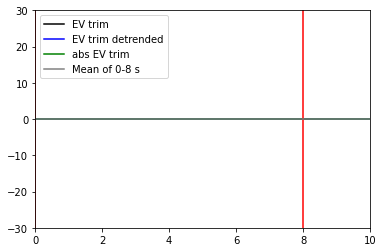

FBRB
100.0
2013-10-31T12:01:38.718393Z


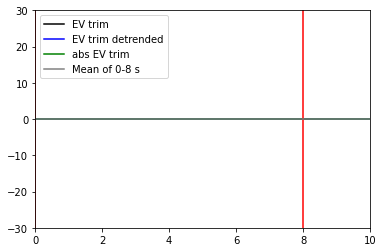

SSTB
100.0
2013-10-31T12:01:38.718391Z


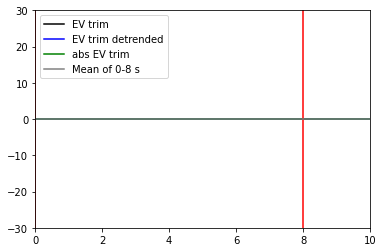

DONB
20.0
2013-10-31T12:01:38.738536Z


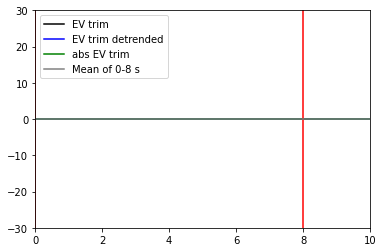

2018-02-04_M6.1
BCWB
TRKB
20.0
2018-02-04T13:56:11.958542Z


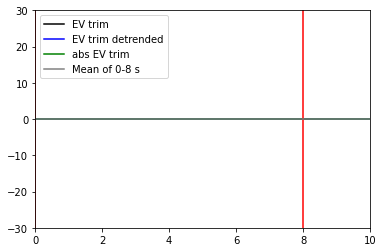

NTTB
SJNB
20.0
2018-02-04T13:56:11.947542Z


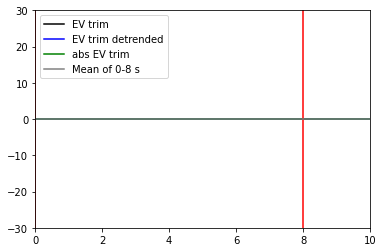

HGSB
20.0
2018-02-04T13:56:11.947542Z


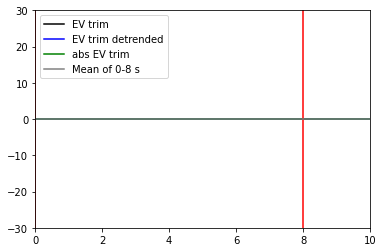

CHMB
20.0
2018-02-04T13:56:11.947542Z


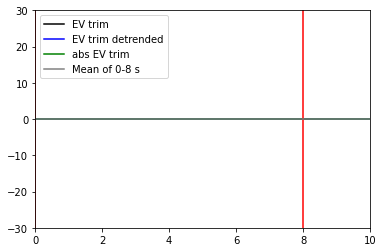

SSNB
20.0
2018-02-04T13:56:11.958542Z


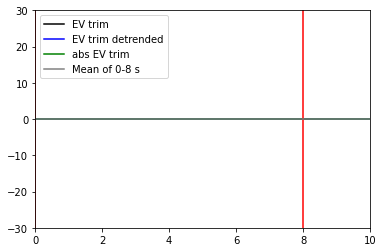

ZANB
20.0
2018-02-04T13:56:11.937542Z


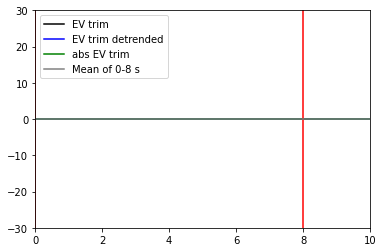

FBRB
20.0
2018-02-04T13:56:11.958542Z


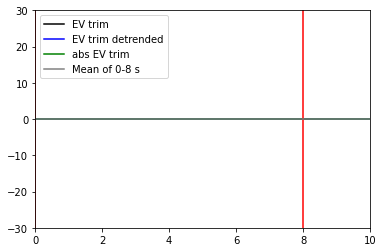

SSTB
20.0
2018-02-04T13:56:11.938542Z


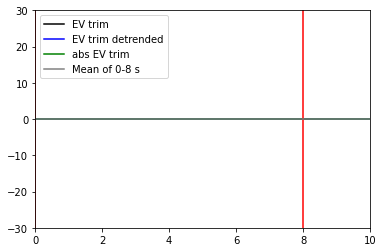

DONB


In [7]:
for i in range(len(events)):
    
    evt_id = events['evt_id'][i]
    print(evt_id)
    origin_time = UTCDateTime(events['origin_time'][i])
    # print(origin_time)
    
    try:
        pick_file = np.genfromtxt(path + 'filtered_uncal/' + evt_id + '/' + 'picks', dtype = str)
    except:
        print('No picks for ' + evt_id)
        continue
    
    pick_rows = []
    for ii in range(len(pick_file)):
        row = pick_file[ii]
        sta_id = row[3].split('.')[1]
        pick_rows.append(sta_id)

    for idx in range(len(stas)):

        sta = stas['Sta'][idx]
        print(sta)
        
        k = np.where(np.array(pick_rows) == sta)[0]
        if len(k) == 0: # No pick for this station, go to next one
            continue
        
        pick_date = pick_file[k,0][0]
        pick_time = pick_file[k,1][0]
        pick_datetime = UTCDateTime(str(pick_date) + 'T' + str(pick_time) + 'Z')
        starttime = pick_datetime - 10 # 10 seconds before pick time
        endtime = starttime + 240 # full trace will be 4 minutes long
    
        try:
            ev = read(path + 'filtered_uncal/' + evt_id + '/' + sta + '.mseed')
            print(ev[0].stats.sampling_rate)
        except:
            print('Missing station ' + sta)
            continue
        # ev.plot()

        stream_starttime = ev[0].stats.starttime
        print(stream_starttime)

        p_arrival_secs = pick_datetime - stream_starttime

        ev_times = ev[0].times()
        ev_data = ev[0].data

        ev_trim = ev.trim(starttime = starttime, endtime = endtime, pad = True, fill_value = 0)
    
        samp_rate = ev[0].stats.sampling_rate
        plt.plot(ev_trim[0].times(), ev_trim[0].data, color = 'black', label = 'EV trim')
    
        # Detrend
        # Figure out which sample has the UTCDateTime P-wave arrival
        utc_times = ev_trim[0].times(type = 'utcdatetime')
        diffs = []
        for time in utc_times:
            diff = np.abs(time - pick_datetime)
            diffs.append(diff)
        l = np.where(np.array(diffs) == np.min(np.array(diffs)))[0]
        utcdt_arrival = utc_times[l][0]
        # l = np.where(utc_times == pick_datetime)[0]
        # print('Actual pick:')
        # print(pick_datetime)
        # print('Closest time in data:')
        # print(utcdt_arrival)
        data_p_arr_idx = np.where(utc_times == utcdt_arrival)[0][0]
        # print(data_p_arr_idx)

        demean_value = np.mean(ev_trim[0].data[data_p_arr_idx-2:data_p_arr_idx+2])
        
        # demean_start = 0
        # demean_end = 8
        # demean_start_samps = int(0*samp_rate)
        # demean_end_samps = int(8*samp_rate)
        # print(ev_trim[0].times()[demean_start_samps])
        # print(ev_trim[0].times()[demean_end_samps])
        # demean_value = np.mean(ev_trim[0].data[demean_start_samps:demean_end_samps])
        ev_trim[0].data = ev_trim[0].data - demean_value
    
        # ev_trim.plot()
        
        # Get an absolute value stream too
        
        ev_trim_abs = ev_trim.copy()
        ev_trim_abs_data = np.abs(ev_trim_abs[0].data)
        ev_trim_abs[0].data = ev_trim_abs_data
        
        # ev_trim_abs.plot()
        
        plt.plot(ev_trim[0].times(), ev_trim[0].data, color = 'blue', label = 'EV trim detrended')
        plt.plot(ev_trim_abs[0].times(), ev_trim_abs[0].data, color = 'green', label = 'abs EV trim')
        plt.axvline(ev_trim[0].times()[0], color = 'red')
        if samp_rate == 20:
            plt.axvline(ev_trim[0].times()[160], color = 'red')
        else:
            plt.axvline(ev_trim[0].times()[800], color = 'red')
        plt.axhline(demean_value, color = 'gray', label = 'Mean of 0-8 s')
        plt.xlim(0,10)
        plt.ylim(-30,30)
        plt.legend()
        plt.show()
    
        # Create folder for the event
        eq_sta_save_dir = path + 'newdetrend_filtered_trimmed_uncal/' + evt_id + '/'
    #                 print(eq_sta_save_dir)
        if os.path.isdir(eq_sta_save_dir):
            pass
        else:
            os.makedirs(eq_sta_save_dir)

        ev_trim.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
        
        # Create folder for the absolute value one
        eq_sta_save_dir = path + 'newdetrend_filtered_trimmed_abs_uncal/' + evt_id + '/'
    #                 print(eq_sta_save_dir)
        if os.path.isdir(eq_sta_save_dir):
            pass
        else:
            os.makedirs(eq_sta_save_dir)

        ev_trim_abs.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')